In [1]:
import torch

In [ ]:
device = torch.device("cuda")
dtype = torch.float64

In [273]:

def load_mnist(**kwargs):
    from tensorflow.keras.datasets.mnist import load_data

    (x_train, _), (x_valid, _) = load_data()
    x_all = np.concatenate((x_train, x_valid))

    # Load as NCHW.
    x_all = x_all[:, np.newaxis, :, :].astype("float32")
    x_all /= 255.0
    y_all = x_all

    return x_all

x_all = torch.tensor(load_mnist(), dtype=dtype, device=device)

In [282]:
from utils.dim import ValidDim

def translate(x, di, dj):
    max_i, max_j = x.size(1), x.size(2)
    pad_i = max(0, di), max(0, -di)
    pad_j = max(0, dj), max(0, -dj)
    return torch.nn.functional.pad(
        x[:, pad_i[1] : max_i - pad_i[0], pad_j[1] : max_j - pad_j[0]],
        (*pad_j, *pad_i),
    )


def mu2d_function(input: torch.Tensor, filter: torch.Tensor, p: torch.Tensor):
    dim = ValidDim(input.size(), filter.size(), p.size())

    upper = (
        torch.zeros((input.size(0), filter.size(0), input.size(2), input.size(3)),
        device=input.device,
        dtype=input.dtype,
        requires_grad=True)
    )
    lower = torch.zeros_like(upper)
    kernel_i, kernel_j, kernel_k = filter.size(1), filter.size(2), filter.size(3)
    for i in range(kernel_i):
        for j in range(kernel_j):
            for k in range(kernel_k):
                window = translate(
                    input[:, i, :, :], kernel_j // 2 - j, kernel_k // 2 - k
                )

                window = window + 1.0

                window = window.unsqueeze(1).repeat(1, filter.size(0), 1, 1) + filter[
                    :, i, j, k
                ].unsqueeze(0).repeat(input.size(0), 1)
                upper = upper + window.pow(p + 1.0)
                lower = lower + window.pow(p)

    mu = upper / lower

    return mu[
        :,
        :,
        dim.padding_row // 2 : dim.padding_row // 2 + dim.output_rows,
        dim.padding_col // 2 : dim.padding_col // 2 + dim.output_cols,
    ]

In [283]:
import numpy as np

In [284]:
import matplotlib.pyplot as plt

In [285]:
from preprocessing.morpho import draw_disk_aa, dilation

In [286]:
filter = torch.tensor(draw_disk_aa(3, (9, 9))[np.newaxis, np.newaxis, :, :], dtype=dtype, device=device)

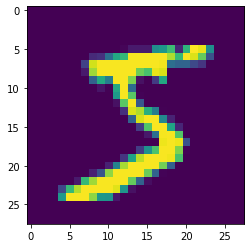

In [287]:
plt.imshow(x_all[0][0].cpu())

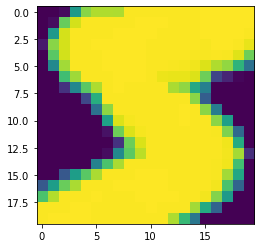

In [288]:
res = mu2d_function(x_all[0:1, :, :, :], filter, torch.ones(1, 1, dtype=dtype, device=device) * 150.0)
 
plt.imshow(res.detach().cpu().squeeze())

In [289]:
target = dilation(x_all[0:1, :, :, :].cpu().numpy().squeeze(), filter.cpu().numpy().squeeze())

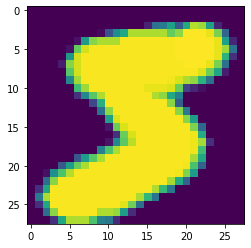

In [290]:
plt.imshow(target)